In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
from __future__ import print_function
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import torch
from torch import nn
from tqdm.auto import tqdm#show loop progress
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import torchvision.models as models


import argparse
import os

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
import torchvision.models as models
import matplotlib.animation as animation
from IPython.display import HTML

from scipy import linalg
from torch.nn.functional import adaptive_avg_pool2d

from PIL import Image

import matplotlib.pyplot as plt
import sys
import numpy as np
import os
# print(os.listdir("../input"))

import time
from torchvision.models.inception import inception_v3
import numpy as np
from scipy.stats import entropy
from torch.autograd import Variable
from torch.nn import functional as F
import torch.utils.data
import torch
from torch import nn

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


/kaggle/input/fashion-mnist-for-dis-score/__results__.html
/kaggle/input/fashion-mnist-for-dis-score/__notebook__.ipynb
/kaggle/input/fashion-mnist-for-dis-score/__output__.json
/kaggle/input/fashion-mnist-for-dis-score/dis_score_loader
/kaggle/input/fashion-mnist-for-dis-score/custom.css
/kaggle/input/fashion-mnist-for-dis-score/data/FashionMNIST/processed/training.pt
/kaggle/input/fashion-mnist-for-dis-score/data/FashionMNIST/processed/test.pt
/kaggle/input/fashion-mnist-for-dis-score/data/FashionMNIST/raw/t10k-labels-idx1-ubyte
/kaggle/input/fashion-mnist-for-dis-score/data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz
/kaggle/input/fashion-mnist-for-dis-score/data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz
/kaggle/input/fashion-mnist-for-dis-score/data/FashionMNIST/raw/train-labels-idx1-ubyte.gz
/kaggle/input/fashion-mnist-for-dis-score/data/FashionMNIST/raw/t10k-images-idx3-ubyte
/kaggle/input/fashion-mnist-for-dis-score/data/FashionMNIST/raw/train-labels-idx1-ubyte
/kaggle/input/fas

In [2]:
class CNN(nn.Module):
    def __init__(self,num_classes=10):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=5, padding=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=5, padding=2),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(2))
        self.fc = nn.Linear(7*7*32, 10)
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(out.size(0), -1)
        out = self.fc(out)
        return out
    
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
cnn_c1 = CNN()
cnn_c1.load_state_dict(torch.load('../input/cnn-c1-fashion-mnist/model.ckpt'))
cnn_c1.eval()

CNN(
  (layer1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Linear(in_features=1568, out_features=10, bias=True)
)

In [3]:
def find_data(trainloader,epoch):
    with torch.no_grad():
        data = []
        for images in trainloader:
            images = images.to('cpu')
            #print(images.size())
            test = Variable(images.float())
            #print(test.size())
            outputs = cnn_c1(test)
            _, predicted = torch.max(outputs.data, 1)
            for i in range(len(images)):
                data.append([images[i],predicted[i]])
    len(data)
    gan_testloader = torch.utils.data.DataLoader(data, batch_size=64, shuffle=True)
    torch.save(gan_testloader, './gan_data_epoch_{}'.format(epoch))

In [4]:
train_loader = torch.load('../input/fashion-mnist-for-dis-score/dis_score_loader')
#test_loader = torch.load('../input/mnist-splitter/svdash_dataloader')
len(train_loader)

625

In [5]:
import torch
import numpy as np
import torchvision

from torch.utils.data import DataLoader
from torch.utils.data import TensorDataset, Dataset
rescale = lambda x: 2 * x -1

class MNISTDS(Dataset):
    def __init__(self, mnist_ds, transform):
        super().__init__()
        self.mnist_ds= mnist_ds
        self.transform = transform
    def __len__(self):
        return len(self.mnist_ds)
    def __getitem__(self, i):
        return self.transform(self.mnist_ds[i][0]), self.mnist_ds[i][1]

#ds = MNISTDS(mnist_ds, transform)

class Generator(nn.Module):
    def __init__(self, latent_size):
        """latent_size = size of the latent space"""
        super(Generator, self).__init__()

        self.latent_size = latent_size

        #kernel size
        self.kernel_size =4
        #(proportional to the) number of generator filters
        self.ngf = 64

        #takes a latent vector and outputs MNIST-sized image
        #input: (_, nz, 1, 1) latent vector
        self.upsample = nn.Sequential(

                                nn.ConvTranspose2d(self.latent_size, 4 * self.ngf, self.kernel_size,
                                                      stride=1,padding=0,bias=False),
                                nn.BatchNorm2d( 4 * self.ngf),
                                nn.ReLU(),
                                #spatial extent here is set by the kernel: (4,4)

                                #by setting stride=2, we effectively double the output size (up to fiddling
                                #with the boundary conditions..)
                                # Weirdly, increasing the 'padding' arg actually decreases the amount of padding
                                #that's applied to the input. the only reason padding is being used here is to
                                #keep the output shapes at nice multiples of two
                                nn.ConvTranspose2d(4 * self.ngf, 2 * self.ngf, self.kernel_size,
                                                      stride=2,padding=1, bias=False),
                                nn.BatchNorm2d( 2 * self.ngf),
                                nn.ReLU(),

                                #( 8,8)
                                nn.ConvTranspose2d(2 * self.ngf, 1 * self.ngf, self.kernel_size,
                                                      stride=2,padding=1, bias=False),
                                nn.BatchNorm2d( 1 * self.ngf),
                                nn.ReLU(),
                                #(16,16)
                                #here I'm increasing the padding to bring the output size to (28,28)
                                #for MNIST
                                nn.ConvTranspose2d(self.ngf, 1, self.kernel_size,
                                                      stride=2,padding=3, bias=False),
                                nn.Tanh(),
                                #(32,32)


                                )

    def forward(self, z):
        """Input: (_, latent_size) noise tensor
            Output: (_, 1, 32, 32) generated image tensor"""
        z = z.view(-1, self.latent_size, 1, 1)
        return self.upsample(z)
    
    

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        #scaling for the number of filters
        self.nf = 64
        # kernel size
        self.kernel_size = 4
        #input (1,28,28)

        #this is more or less the generator stack run in reverse
        # a stride of 2 and padding of 1 causes the spatial extent to halve at each step
        self.main = nn.Sequential(
            nn.Conv2d(1, self.nf, self.kernel_size, stride=2,padding=3, bias=False),
            nn.LeakyReLU(.2),
            nn.Conv2d(self.nf, 2 * self.nf, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(2 * self.nf),
            nn.LeakyReLU(.2),
            nn.Conv2d(2*self.nf, 4 * self.nf, self.kernel_size, stride=2, padding=1, bias=False),
            nn.BatchNorm2d(4 * self.nf),
            nn.LeakyReLU(.2),
            nn.Conv2d(4*self.nf, 1 , self.kernel_size, stride=1, padding=0, bias=False),
            nn.Sigmoid()

        )

    def forward(self, x):
        """Input: (_, 1, 28, 28) image
            Output: (_, 1) classification tensor"""
        x = x.view(-1, 1, 28,28)
        return self.main(x).view(-1)

devname = "cuda:0" if torch.cuda.is_available() else "cpu"

device = torch.device(devname)

latent_size = 100

def weight_init(module):
    classname = module.__class__.__name__
    if classname.find('Conv')!=-1:
        module.weight.data.normal_(0.0, .02)
    elif classname.find('BatchNorm') != -1:
        module.weight.data.normal_(1.0, .01)
        module.bias.data.fill_(0.0)



G = Generator(latent_size).to(device)
D = Discriminator().to(device)

G.apply(weight_init)
D.apply(weight_init)

batch_size = 64

dl = train_loader#DataLoader(ds, batch_size=batch_size, shuffle=True)

loss = nn.BCELoss()

real_label = 1
fake_label = 1- real_label

lr = 2e-4
beta=.5

#One optimizer for each network. Makes it easy to update the two different sets of weights in alternating steps.

optimizerD = torch.optim.Adam(D.parameters(), lr=lr,betas=(beta, .999))
optimizerG = torch.optim.Adam(G.parameters(), lr=lr,betas=(beta, .999))

#How many passes to take over the dataset.

epochs = 201

disc_losses = []
gen_losses = []

savestep=0
generated_images = []
psnr_score = []
mmd_score = []
fid_score = []
is_score= []
checkpoint = [1,10,20,30,40,50,100,150,200]
for epoch in range(epochs):
    fake_image_array = []
    real_array = []
    print("Starting epoch %d..." % epoch)
    for i, (x,y) in enumerate(dl):
        x = x.to(device)
        y = y.to(device)

        #size of current batch
        N = x.shape[0]
        ## update the discriminator
        disc_real = D(x)
        real_probs = torch.full((N,), real_label, device=device).type('torch.FloatTensor').cuda()
        #print(real_probs.type())
        disc_loss_real = loss(disc_real, real_probs)

        z = torch.randn(N, latent_size,1,1,device=device)
        #detach here, so gradients don't flow to the generator
        fake_outputs = G(z).detach()
        
        if epoch in checkpoint:
            generated_images.append(fake_outputs)
            fake_image_array.append(fake_outputs)
            real_array.append(x)
        
        disc_fake = D(fake_outputs)
        fake_probs = torch.full((N,), fake_label, device=device).type('torch.FloatTensor').cuda()
        disc_loss_fake = loss(disc_fake, fake_probs)

        D.zero_grad()
        disc_loss = disc_loss_real+ disc_loss_fake
        disc_loss.backward()
        #update disc weights only
        optimizerD.step()

        ## update the generator
        z = torch.randn(N, latent_size, 1, 1, device=device)
        disc_fake = D(G(z))
        fake_labels = torch.full((N,), real_label, device=device).type('torch.FloatTensor').cuda()
        gen_loss = loss(disc_fake, fake_labels)

        G.zero_grad()
        gen_loss.backward()
        optimizerG.step()   

        if i % 25 ==0:
            print("[Epochs:%d],[generator_loss:%f],[disc_loss:%f]"% (epoch,gen_loss.item(),disc_loss.item()))
            disc_losses.append(disc_loss.item())
            gen_losses.append(gen_loss.item())
    
    if epoch in checkpoint:
        print("========E=======P========O========C=========H=======:",epoch)
        temp_image = []
        for curr in generated_images:
            for i in curr:
                temp_image.append(i)
        trainloader = torch.utils.data.DataLoader(temp_image, batch_size=64, shuffle=True)
        find_data(trainloader,epoch)
        generated_images = []


Starting epoch 0...
[Epochs:0],[generator_loss:1.261781],[disc_loss:1.828431]
[Epochs:0],[generator_loss:5.128160],[disc_loss:0.552617]
[Epochs:0],[generator_loss:2.035816],[disc_loss:0.621187]
[Epochs:0],[generator_loss:2.309852],[disc_loss:0.266086]
[Epochs:0],[generator_loss:3.377868],[disc_loss:0.188561]
[Epochs:0],[generator_loss:5.379726],[disc_loss:0.647333]
[Epochs:0],[generator_loss:3.485066],[disc_loss:0.278496]
[Epochs:0],[generator_loss:3.133988],[disc_loss:0.221562]
[Epochs:0],[generator_loss:3.394280],[disc_loss:0.217237]
[Epochs:0],[generator_loss:3.705559],[disc_loss:0.187939]
[Epochs:0],[generator_loss:3.788581],[disc_loss:0.119090]
[Epochs:0],[generator_loss:5.998118],[disc_loss:1.168800]
[Epochs:0],[generator_loss:4.081943],[disc_loss:0.180620]
[Epochs:0],[generator_loss:3.071357],[disc_loss:0.167068]
[Epochs:0],[generator_loss:3.116505],[disc_loss:0.189492]
[Epochs:0],[generator_loss:4.580208],[disc_loss:0.143388]
[Epochs:0],[generator_loss:4.263199],[disc_loss:0.09

/opt/conda/lib/python3.7/site-packages/matplotlib/text.py:1165: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


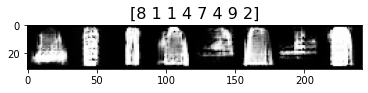

In [6]:
test = torch.load('./gan_data_epoch_1')
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
for batch_idx, (temp, target) in enumerate(test):
    img_grid = make_grid(temp[0:8,], nrow=8)
    img_target_labels = target[0:8,].numpy()
    break
    
plt.imshow(img_grid.detach().cpu().numpy().transpose((1,2,0)))
plt.rcParams['figure.figsize'] = (10, 2)
plt.title(img_target_labels, size=16)
plt.show()

In [7]:
len(test)

625